import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as sci_wav # Open wav files
import librosa
import librosa.display as libdisplay
from scipy.signal import resample, butter, filtfilt
import sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
import glob 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.signal import savgol_filter

### 1 sec samples

In this section, we define the paths for the different types of audio samples that will be used in our project.

- The `road_samples_path` variable points to the directory containing the road audio samples. It is set to `"d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\training_set\\road\\"`.

- The `tunnel_samples_path` variable points to the directory containing the tunnel audio samples. It is set to `"d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\training_set\\tunnel\\"`.

- The `rt_samples_path` variable is used for storing new audio samples. It is set to `"d:\\DSUsers\\uic74928\\Komponente\\CNN\\new_samples\\"`.

These paths will be utilized throughout the notebook for loading and processing the audio data.


In [28]:
road_samples_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\training_set\\road\\"
tunnel_samples_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\training_set\\tunnel\\"
rt_samples_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\new_samples\\"

In [4]:
road_wav_path = road_samples_path
road_tunnel_wav_path = tunnel_samples_path


In [5]:
print(road_wav_path, road_tunnel_wav_path)

d:\DSUsers\uic74928\Komponente\CNN\audio_samples\training_set\road\ d:\DSUsers\uic74928\Komponente\CNN\audio_samples\training_set\tunnel\


###                        Define constants


In [10]:
fs = 8000 # target freq
audio_sample_length = 1 # sec of signals
ts = 0.3 # seconds for FFT

In [11]:
# -1 to 1
road_wav = 1.0 * sci_wav.read(road_wav_path + "12_1.wav")[1]
tunnel_wav = 1.0 * sci_wav.read(road_tunnel_wav_path + "12_1.wav")[1]
rt_wav = 1.0 * sci_wav.read(rt_samples_path + "show_case.wav")[1]

### Remove the mean from signals

In [12]:
# Calculate the mean values
mean_road_value = np.mean(road_wav)
mean_tunnel_value = np.mean(tunnel_wav)
# Remove the mean from signals
road_wav = road_wav - mean_road_value
tunnel_wav = tunnel_wav - mean_tunnel_value

### Short-Time Fourier Transform (STFT) and Mel Spectrogram Calculation

In this code snippet, we perform the Short-Time Fourier Transform (STFT) and calculate the corresponding Mel spectrogram for a given audio signal.

- The `Nfft` variable represents the number of points to be used for the Fast Fourier Transform (FFT) computation. It is set to `16384`.

- The `hop_length` variable determines the number of samples to skip between successive STFT frames. It is calculated as `Nfft / 16` (integer division).

- The `rt_stft` variable stores the magnitude spectrogram obtained from applying the STFT to the `rt_wav` audio signal. It is computed using the `librosa.stft` function with the specified parameters.

- The `rt_stft_mel` variable represents the Mel spectrogram derived from the squared magnitude of the STFT spectrogram. It is calculated using `librosa.feature.melspectrogram`, considering the squared STFT spectrogram, a sampling rate of 48000 Hz, the specified `Nfft` and `hop_length` values, and a power of 1.

- The `rt_stft_mel` Mel spectrogram is converted to a logarithmic scale using `librosa.power_to_db`, with a reference level set to the maximum value.

- The `vmin` variable stores the minimum value in the `rt_stft_mel` Mel spectrogram.

- The `vmax` variable stores the maximum value in the `rt_stft_mel` Mel spectrogram.

These variables and calculations are used for further analysis and visualization of the audio data.


In [16]:
Nfft = 16384
hop_length = int(Nfft / 16)

rt_stft = np.abs(librosa.stft(y=rt_wav, n_fft=Nfft, hop_length=hop_length, window='blackman'))
rt_stft_mel = librosa.feature.melspectrogram(S=rt_stft ** 2, sr=48000, n_fft=Nfft, hop_length=hop_length, power=1)
rt_stft_mel = librosa.power_to_db(rt_stft_mel, ref=np.max)

vmin = np.min(rt_stft_mel)
vmax = np.max(rt_stft_mel)

### Calculation of Short-Time Energy and Time Axis

In this code snippet, we calculate the short-time energy and create the corresponding time axis for the audio signal.

- The `short_time_energy` variable represents the sum of the Mel spectrogram values along the axis 0 (across time frames). It is computed using the `np.sum` function applied to the `rt_stft_mel` Mel spectrogram.

- The `t` variable is used to create the time axis corresponding to the frames of the short-time energy. It is obtained by converting the frame indices to time values using the `librosa.frames_to_time` function. The function takes into account a sampling rate of 48000 Hz and the specified `hop_length` value.

The `short_time_energy` and `t` variables provide information about the energy distribution and the corresponding time values for the audio signal frames, respectively. They can be utilized for various analysis and visualization purposes.


In [18]:
# # Calculate the Short-Time Energy
short_time_energy = np.sum(rt_stft_mel, axis=0)

# # Create the time axis
t = librosa.frames_to_time(range(len(short_time_energy)), sr=48000, hop_length=hop_length)

### Visualization of Mel-Scale Power Spectrogram and Short-Time Energy

This code snippet visualizes the Mel-scale power spectrogram and the short-time energy of an audio sample.


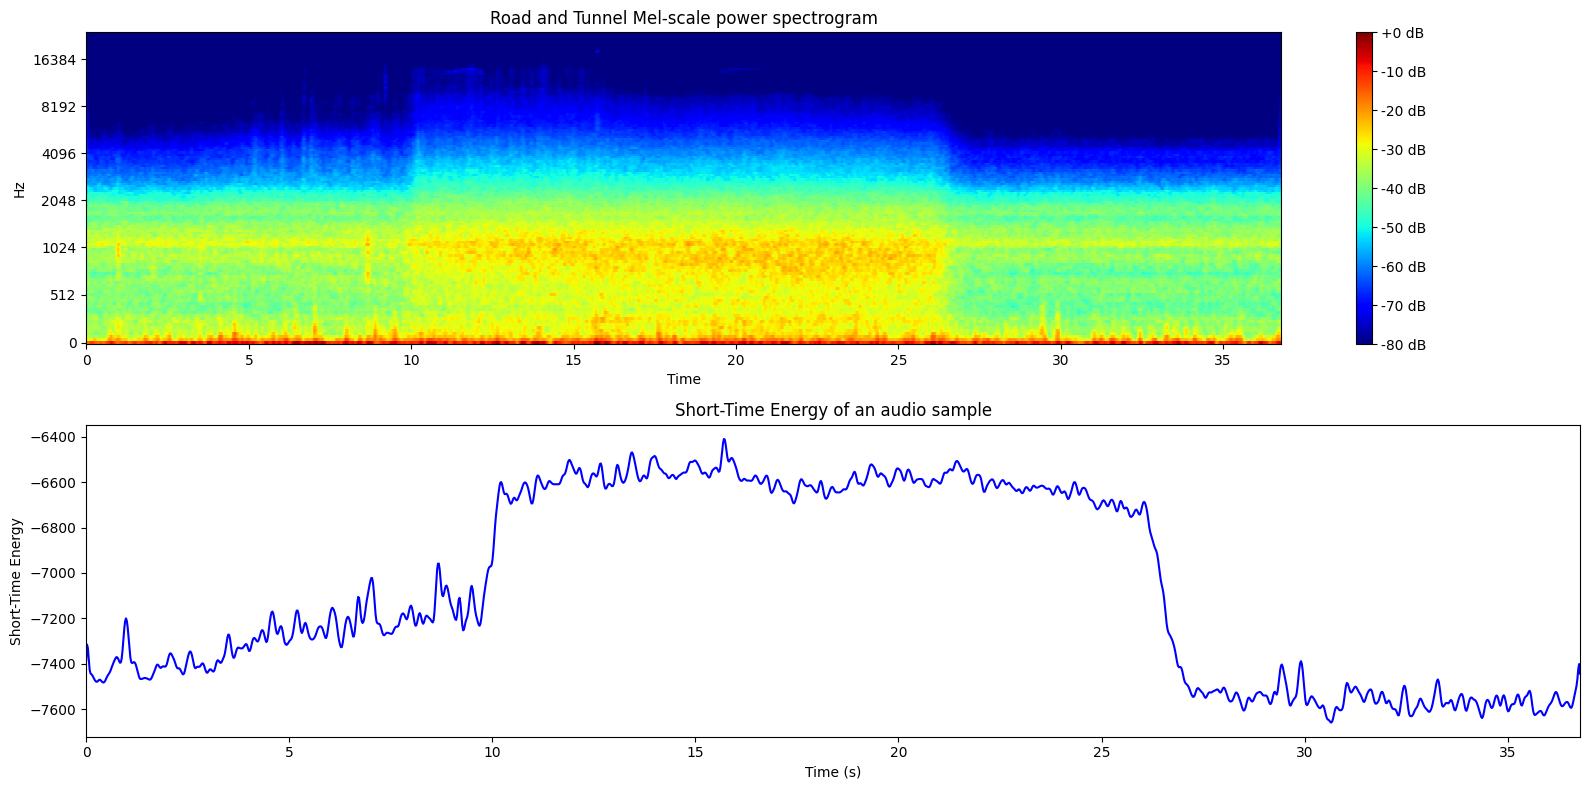

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(211)
librosa.display.specshow(rt_stft_mel, sr=48000, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(format='%+2.0f dB')
plt.title("Road and Tunnel" + ' Mel-scale power spectrogram')

plt.subplot(212)
plt.plot(t, short_time_energy, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Short-Time Energy')
plt.title('Short-Time Energy of an audio sample')
plt.xlim(0, max(t))

plt.tight_layout()
plt.show()

### Calculation of Spectrograms for Road and Tunnel Audio Samples

In this code snippet, we calculate the spectrograms for the road and tunnel audio samples.

- The `Nfft` variable represents the number of points to be used for the Fast Fourier Transform (FFT) computation. It is calculated as the product of the sampling rate (`fs`) and the desired time resolution (`ts`).

- The `window_step` variable determines the number of samples to skip between successive FFT frames. It is set to half of the `Nfft` value.

- The `road_spec` variable stores the spectrogram of the `road_wav` audio signal. It is computed by applying the Short-Time Fourier Transform (STFT) to the `road_wav` signal using the `librosa.stft` function. The STFT is calculated with a specified `n_fft` value of `Nfft` and a `hop_length` value of `window_step`. The magnitude of the STFT is converted to decibels using `librosa.amplitude_to_db` with a reference level set to the maximum value.

- Similarly, the `tunnel_spec` variable stores the spectrogram of the `tunnel_wav` audio signal. It is calculated using the same procedure as for the `road_spec`.

The `road_spec` and `tunnel_spec` variables contain the spectrogram representations of the road and tunnel audio samples, respectively. These spectrograms provide valuable insights into the frequency content and time-varying characteristics of the audio signals.


In [20]:
Nfft = int(fs*ts)
window_step = int(Nfft/2)

road_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y = road_wav, n_fft = Nfft, hop_length = window_step)), ref=np.max)
tunnel_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y = tunnel_wav, n_fft = Nfft, hop_length = window_step)), ref=np.max)


### Visualization of Linear-Frequency Power Spectrograms for Road and Tunnel Audio Samples

This code snippet visualizes the linear-frequency power spectrograms for the road and tunnel audio samples.


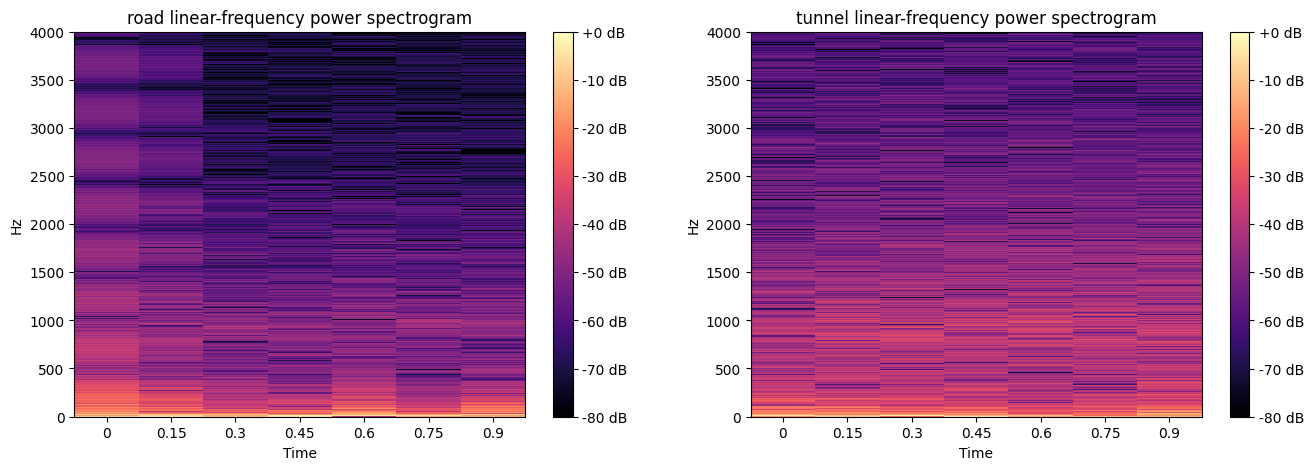

In [21]:
plt.figure(figsize=(16,5))
plt.subplot(121)
libdisplay.specshow(road_spec, y_axis='linear', sr = fs, x_axis = 'time', hop_length = window_step)
plt.colorbar(format='%+2.0f dB')
plt.title("road" + ' linear-frequency power spectrogram')

plt.subplot(122)
libdisplay.specshow(tunnel_spec, y_axis='linear', sr = fs, x_axis = 'time', hop_length = window_step)
plt.colorbar(format='%+2.0f dB')
plt.title("tunnel" + ' linear-frequency power spectrogram')
plt.show()

### Fixing the Length of Road and Tunnel Audio Samples if Samples are Longer than 1 second

In this code snippet, the length of the road and tunnel audio samples is fixed to a specific duration.

- The `fix_length_s` variable represents the desired fixed length in seconds for the audio samples. This value is assumed to be stored in the `audio_sample_length` variable.

- The `fix_length` variable is calculated by multiplying the desired fixed length (`fix_length_s`) by the sampling rate (`fs`) and converting it to an integer.

- The `road_wav_sig` variable stores the road audio sample with the fixed length. It is obtained by using the `librosa.util.fix_length` function, which fixes the length of the audio sample to `fix_length` by either wrapping or truncating the signal. In this case, the `size` parameter is set to `fix_length`, the `axis` parameter is set to 0 (indicating the time axis), and the `mode` parameter is set to 'wrap'.

- Similarly, the `tunnel_wav_sig` variable stores the tunnel audio sample with the fixed length using the same procedure as for the road audio sample.

The `road_wav_sig` and `tunnel_wav_sig` variables now contain the road and tunnel audio samples, respectively, with a fixed duration of `fix_length_s` seconds. This ensures that the samples have consistent lengths for further processing and analysis.


In [23]:
# Pick the fixed length in seconds
fix_length_s = audio_sample_length
fix_length = int(fix_length_s*fs)

road_wav_sig = librosa.util.fix_length(road_wav, size = fix_length, axis=0, mode = 'wrap')
tunnel_wav_sig = librosa.util.fix_length(tunnel_wav, size = fix_length, axis=0, mode = 'wrap')



### Calculation of Mel-Spectrograms and MFCCs for Road and Tunnel Audio Samples

In this code snippet, we calculate the Mel-spectrograms and Mel-frequency cepstral coefficients (MFCCs) for the road and tunnel audio samples.

- The `n_mels` variable represents the number of mel filterbanks to be used for the mel spectrogram calculation.

- The `Nfft` variable is calculated as the product of the sampling rate (`fs`) and the desired time resolution (`ts`).

- The `window_step` variable determines the number of samples to skip between successive frames in the spectrogram calculation. It is set to a quarter of the `Nfft` value.

- The `f_min` and `f_max` variables define the frequency range for the mel filterbanks.

- The `S_road` variable stores the mel-spectrogram of the road audio sample. It is calculated using the `librosa.feature.melspectrogram` function, which takes the `road_wav_sig` audio signal as input, along with the sampling rate (`fs`), the `Nfft` value, the `window_step`, the power parameter set to 2.0 for squared magnitudes, and the specified `n_mels`. The resulting spectrogram is then converted to decibels using `librosa.power_to_db` with a reference level set to the maximum value.

- Similarly, the `S_tunnel` variable stores the mel-spectrogram of the tunnel audio sample, using the same procedure as for the road audio sample.

- The `mfcc_road` variable represents the MFCCs of the road audio sample. It is computed using the `librosa.feature.mfcc` function, which takes the sampling rate (`fs`), the `S_road` mel-spectrogram, and the desired number of MFCCs (`n_mfcc`) as inputs.

- Likewise, the `mfcc_tunnel` variable contains the MFCCs of the tunnel audio sample, calculated using the `S_tunnel` mel-spectrogram.

The `S_road`, `S_tunnel`, `mfcc_road`, and `mfcc_tunnel` variables now store the mel-spectrograms and MFCCs, respectively, for the road and tunnel audio samples. These representations are widely used in audio analysis and can provide valuable information about the spectral characteristics and timbral features of the audio signals.


In [24]:
n_mels = 40
Nfft = int(fs*ts)
window_step = int(Nfft/4)

# # Define the frequency range
f_min = 512
f_max = 2000

S_road = librosa.feature.melspectrogram(y=road_wav_sig, sr=fs, S=None, n_fft=Nfft, hop_length = window_step, power=2.0, n_mels = n_mels)
S_tunnel = librosa.feature.melspectrogram(y=tunnel_wav_sig, sr=fs, S=None, n_fft=Nfft, hop_length = window_step, power=2.0, n_mels = n_mels)
S_road = librosa.power_to_db(S_road, ref=np.max)
S_tunnel = librosa.power_to_db(S_tunnel, ref=np.max)

mfcc_road = librosa.feature.mfcc(sr=fs, S=S_road, n_mfcc=15)
mfcc_tunnel = librosa.feature.mfcc(sr=fs, S=S_tunnel, n_mfcc=15)



### Calculation of Filtered Mel-Spectrograms and MFCCs for Road and Tunnel Audio Samples

In this code snippet, we calculate the filtered Mel-spectrograms and Mel-frequency cepstral coefficients (MFCCs) for the road and tunnel audio samples.

- The `S_road_filtered` variable stores the filtered mel-spectrogram of the road audio sample. It is calculated using the `librosa.feature.melspectrogram` function, similar to the previous calculation, but with additional parameters `fmin` and `fmax` set to `f_min` and `f_max` respectively. These parameters define the frequency range to be considered for the mel filterbanks.

- Similarly, the `S_tunnel_filtered` variable stores the filtered mel-spectrogram of the tunnel audio sample, calculated using the same procedure as for the road audio sample.

- The filtered mel-spectrograms `S_road_filtered` and `S_tunnel_filtered` are then converted to decibels using `librosa.power_to_db` with a reference level set to the maximum value.

- The `mfcc_road_filtered` variable represents the MFCCs of the road audio sample, computed using the `librosa.feature.mfcc` function, similar to the previous calculation, but using the `S_road_filtered` mel-spectrogram.

- Likewise, the `mfcc_tunnel_filtered` variable contains the MFCCs of the tunnel audio sample, calculated using the `S_tunnel_filtered` mel-spectrogram.

The `S_road_filtered`, `S_tunnel_filtered`, `mfcc_road_filtered`, and `mfcc_tunnel_filtered` variables now store the filtered mel-spectrograms and MFCCs, respectively, for the road and tunnel audio samples. By applying the frequency range filter, these representations focus on a specific range of frequencies, which can be useful for certain applications that require a narrower frequency band analysis.


In [25]:
# filter MEL
S_road_filtered = librosa.feature.melspectrogram(y=road_wav_sig, sr=fs, S=None, n_fft=Nfft, hop_length = window_step, power=2.0, n_mels = n_mels, fmin=f_min, fmax=f_max)
S_tunnel_filtered = librosa.feature.melspectrogram(y=tunnel_wav_sig, sr=fs, S=None, n_fft=Nfft, hop_length = window_step, power=2.0, n_mels = n_mels, fmin=f_min, fmax=f_max)
S_road_filtered = librosa.power_to_db(S_road_filtered, ref=np.max)
S_tunnel_filtered = librosa.power_to_db(S_tunnel_filtered, ref=np.max)

mfcc_road_filtered = librosa.feature.mfcc(sr=fs, S=S_road_filtered, n_mfcc=15)
mfcc_tunnel_filtered = librosa.feature.mfcc(sr=fs, S=S_tunnel_filtered, n_mfcc=15)


### Visualization of Mel-Spectrograms

In this code snippet, the mel-spectrograms of the road and tunnel audio samples, both with and without frequency range filtering, are visualized using matplotlib.


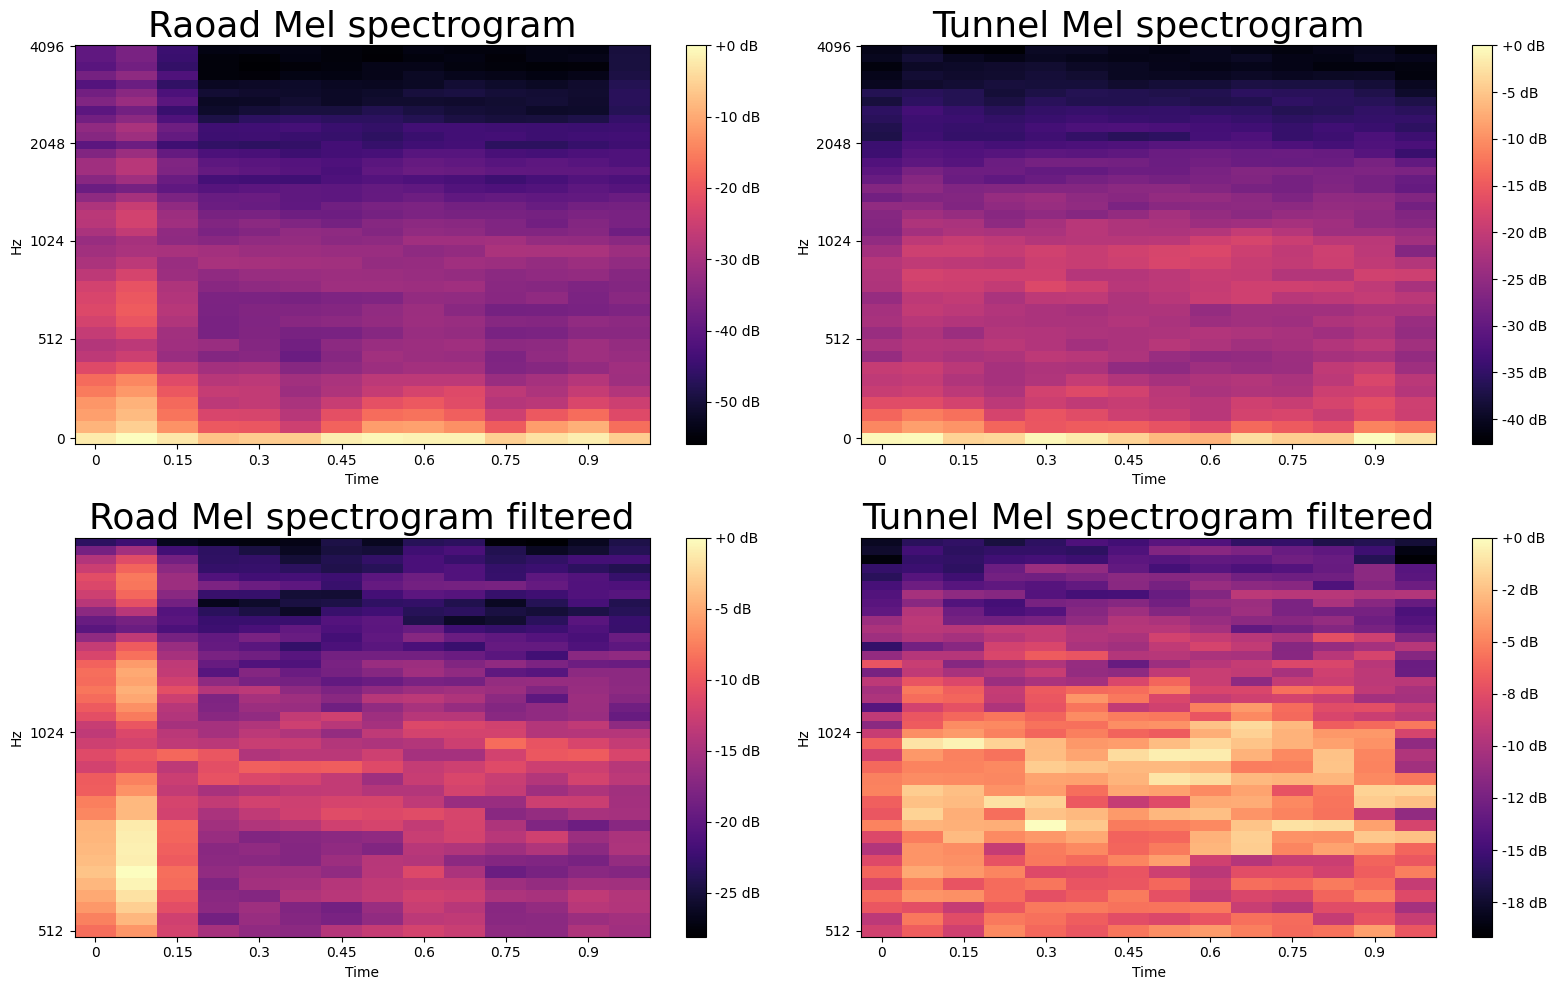

In [26]:
plt.figure(figsize=(16, 10))

# First row
plt.subplot(221)
librosa.display.specshow(S_road, sr=fs, y_axis='mel', x_axis='time', hop_length=window_step, fmax=fs/2)
plt.colorbar(format='%+2.0f dB')
plt.title('Raoad Mel spectrogram', fontsize=26)

plt.subplot(222)
librosa.display.specshow(S_tunnel, sr=fs, y_axis='mel', x_axis='time', hop_length=window_step, fmax=fs/2)
plt.colorbar(format='%+2.0f dB')
plt.title('Tunnel Mel spectrogram', fontsize=26)

# Second row
plt.subplot(223)
librosa.display.specshow(S_road_filtered, sr=fs, y_axis='mel', fmin=f_min, fmax=f_max, x_axis='time', hop_length=window_step)
plt.colorbar(format='%+2.0f dB')
plt.title('Road Mel spectrogram filtered', fontsize=26)

plt.subplot(224)
librosa.display.specshow(S_tunnel_filtered, sr=fs, y_axis='mel', fmin=f_min, fmax=f_max, x_axis='time', hop_length=window_step)
plt.colorbar(format='%+2.0f dB')
plt.title('Tunnel Mel spectrogram filtered', fontsize=26)

plt.tight_layout()

### Visualization of MFCCs

In this code snippet, the MFCCs (Mel-frequency cepstral coefficients) of the road and tunnel audio samples, both with and without frequency range filtering, are visualized using matplotlib.


C:\Users\uic74928\AppData\Local\Temp\ipykernel_34276\3832335049.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)
C:\Users\uic74928\AppData\Local\Temp\ipykernel_34276\3832335049.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


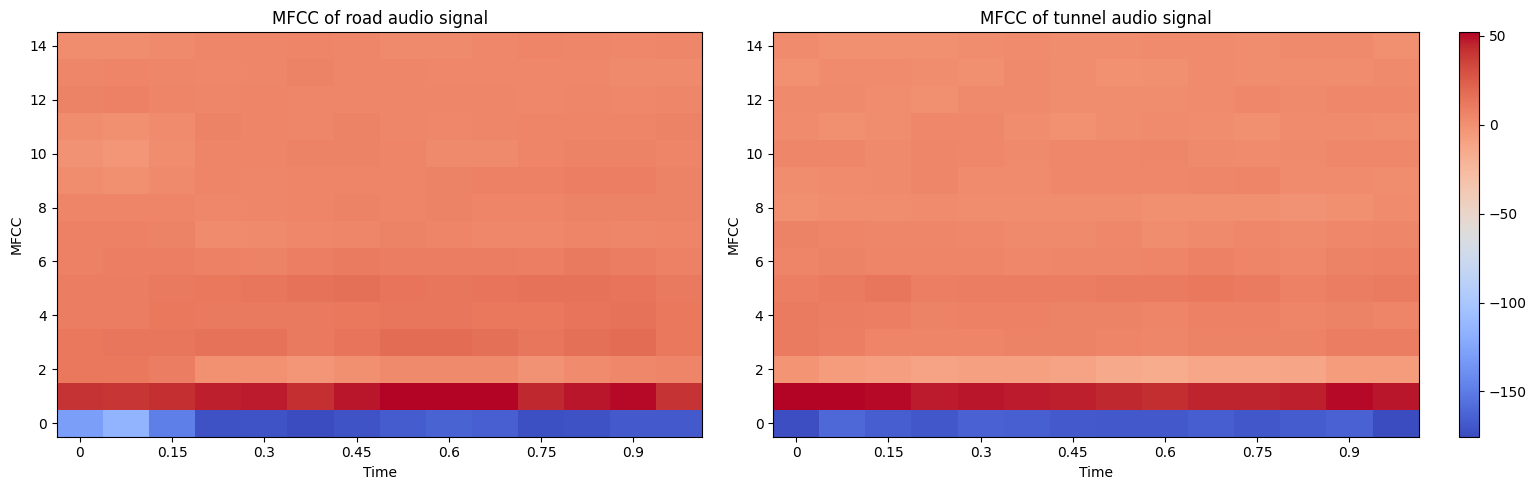

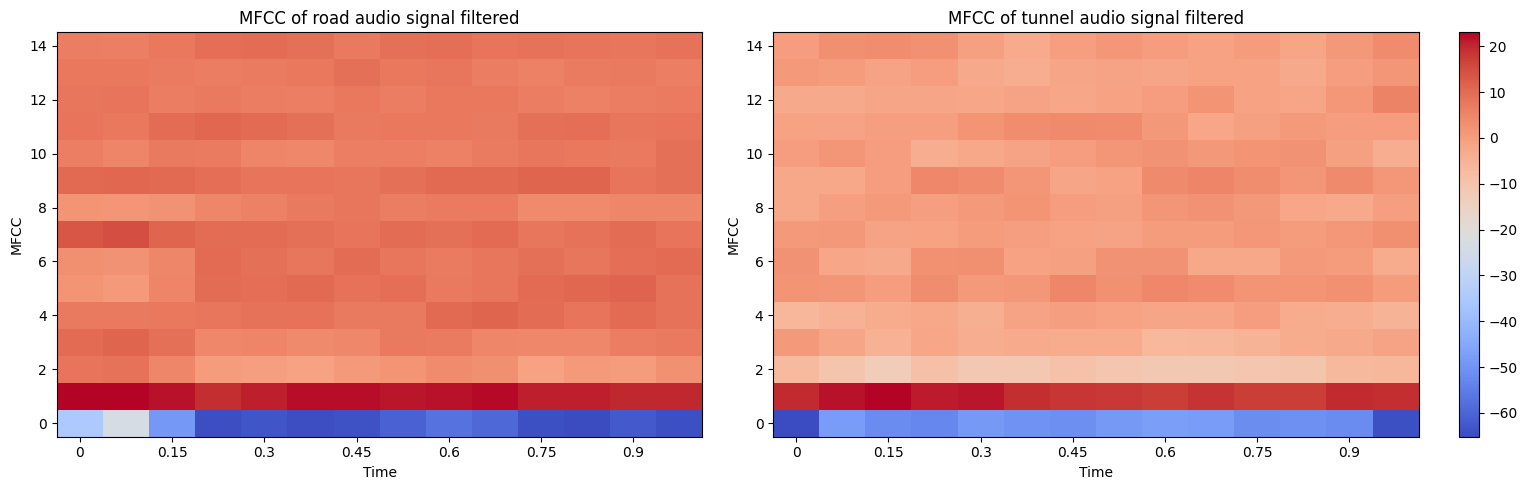

In [27]:

plt.figure(figsize=(16,5))
plt.subplot(121)
librosa.display.specshow(mfcc_road, sr = fs, x_axis='time', hop_length = window_step, y_axis = 'frames')
plt.colorbar()
plt.ylabel('MFCC')
plt.title(f'MFCC of road audio signal')
plt.tight_layout()

plt.subplot(122)
librosa.display.specshow(mfcc_tunnel, sr = fs, x_axis='time', hop_length = window_step, y_axis = 'frames')
plt.colorbar()
plt.ylabel('MFCC')
plt.title(f'MFCC of tunnel audio signal')
plt.tight_layout()

plt.figure(figsize=(16,5))
plt.subplot(121)

librosa.display.specshow(mfcc_road_filtered, sr = fs, x_axis='time', hop_length = window_step, y_axis = 'frames')
plt.colorbar()
plt.ylabel('MFCC')
plt.title(f'MFCC of road audio signal filtered')
plt.tight_layout()

plt.subplot(122)
librosa.display.specshow(mfcc_tunnel_filtered, sr = fs, x_axis='time', hop_length = window_step, y_axis = 'frames')
plt.colorbar()
plt.ylabel('MFCC')
plt.title(f'MFCC of tunnel audio signal filtered')
plt.tight_layout()